# 0. 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.datasets import load_breast_cancer

import xgboost
from xgboost import XGBClassifier

import time

In [2]:
print("library version check")
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", mpl.__version__)
print("sklearn: ", sklearn.__version__)
print("xgboost: ", xgboost.__version__)

library version check
numpy:  1.23.5
pandas:  1.5.1
seaborn:  0.12.1
matplotlib:  3.6.2
sklearn:  1.1.3
xgboost:  2.0.3


In [3]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

# 1. breast_cancer

In [4]:
cancer = load_breast_cancer()

In [5]:
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [6]:
## 학습시킬 feature와 label 분류해보자.
## cancer를 이용해서 필요한 정보를 가져와 보자.
x_data = cancer["data"]
y_data = cancer["target"]

In [7]:
## 학습과 테스트 데이터로 분류해보자.
## test_size=0.20, random_state = 42, stratify=y_data 설정
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size = 0.20,
                                                    random_state = 42,
                                                    stratify = y_data)

In [8]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (455, 30)
y_train:  (455,)
x_test:  (114, 30)
y_test:  (114,)


**Adaboost**

In [9]:
base = DecisionTreeClassifier(max_depth = 1, random_state=42)

ada = AdaBoostClassifier(n_estimators= 1, base_estimator = base)
ada.fit(x_train, y_train)
pred_ada = ada.predict(x_test)
print('The accuracy of the Adaboost is', 
      metrics.accuracy_score(pred_ada, y_test))

The accuracy of the Adaboost is 0.9210526315789473


In [10]:
ada_acc = []

for i in range(1, 30):
    base = DecisionTreeClassifier(max_depth = 1, random_state=42)
    ada = AdaBoostClassifier(n_estimators= i, base_estimator = base)
    ada.fit(x_train, y_train)
    pred_ada = ada.predict(x_test)
    ada_acc.append(metrics.accuracy_score(pred_ada, y_test))

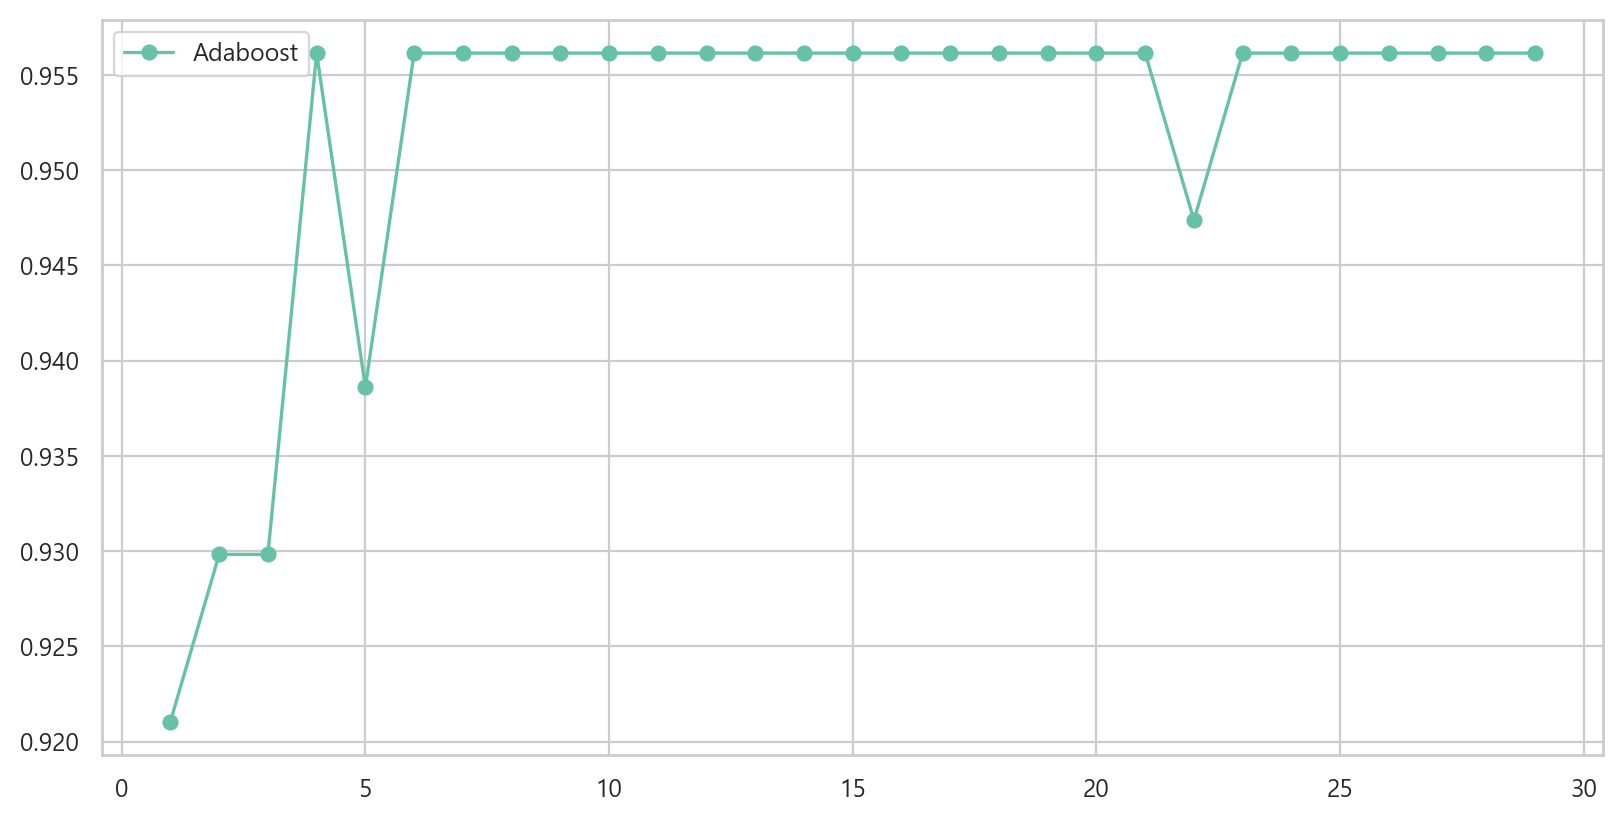

In [11]:
## ada의 n_estimator 변화에 따른 ada_acc plot을 그리시오
fig, ax = plt.subplots(figsize = (8,4))

ax.plot(range(1, 30), ada_acc, marker = "o", label = "Adaboost")

ax.legend();

* Adaboost는 약한 학습기(우연보다 조금 나은 성능을 내는 머신러닝 모델)를 통해 반복적으로 오류를 고치는데 초점을 맞춘 모델
* 따라서 베이스 모델이 강력하면 학습 과정이 제한되어 부스팅 모델의 전략을 약화시킴. 즉, 성능이 올라가지 않을 수 있음

**XGBoost**

* [XGBoost 공식문서](https://xgboost.readthedocs.io/en/stable/parameter.html)

* booster: gbtree
* objective
    * 다중분류
        * multi:sotfmax
    * 이진분류
        * binary:logistic
    * 회귀
        * reg:squarederror
* max_depth: xgboost의 깊이는 6이 default
* learning_rate & n_estimators: learning_rate를 줄이고, n_estimators를 높이면 성능을 올릴 수 있음

In [12]:
# gridsearch
def grid_search(params, model, core):
    model_grid = GridSearchCV(model, 
                              params, 
                              cv=5, 
                              return_train_score=True,
                              n_jobs = core
                             )
    model_grid.fit(x_train, y_train)
    
    print('최상의 매개변수: ', model_grid.best_params_)
    print('훈련 데이터의 최고 정확도: ', model_grid.best_score_)
    
    model_best = model_grid.best_estimator_
    pred_best = model_best.predict(x_test)
    print('테스트 데이터의 최고 정확도: ', metrics.accuracy_score(pred_best, y_test))

In [13]:
params = {"max_depth": [1, 2, 3],
          "learning_rate" : np.arange(0.01, 0.1, 0.005),
          "n_estimators": np.arange(100, 300, 30)}

In [15]:
xgb = XGBClassifier(booster = "gbtree", 
                    objective = "binary:logistic")

In [16]:
%%time
# grid_search(params, xgb, -1)

최상의 매개변수:  {'learning_rate': 0.08999999999999998, 'max_depth': 3, 'n_estimators': 220}
훈련 데이터의 최고 정확도:  0.9780219780219781
테스트 데이터의 최고 정확도:  0.9473684210526315
CPU times: total: 11.8 s
Wall time: 2min 36s


In [20]:
xgb_best = XGBClassifier(booster = "gbtree", 
                         objective = "binary:logistic",
                         learning_rate = 0.09, 
                         max_depth = 3,
                         n_estimators = 220)

In [21]:
xgb_best.fit(x_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=220, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
xgb_best.feature_importances_

array([0.        , 0.01141473, 0.        , 0.01288546, 0.0055139 ,
       0.00326216, 0.00463504, 0.06704083, 0.00146801, 0.00570424,
       0.01338138, 0.03464879, 0.00757216, 0.00876167, 0.0224753 ,
       0.00361963, 0.0035476 , 0.00092238, 0.00139045, 0.00329153,
       0.33441934, 0.01989267, 0.29800063, 0.02309512, 0.01265894,
       0.02291789, 0.01415997, 0.05774943, 0.00372972, 0.00184099],
      dtype=float32)

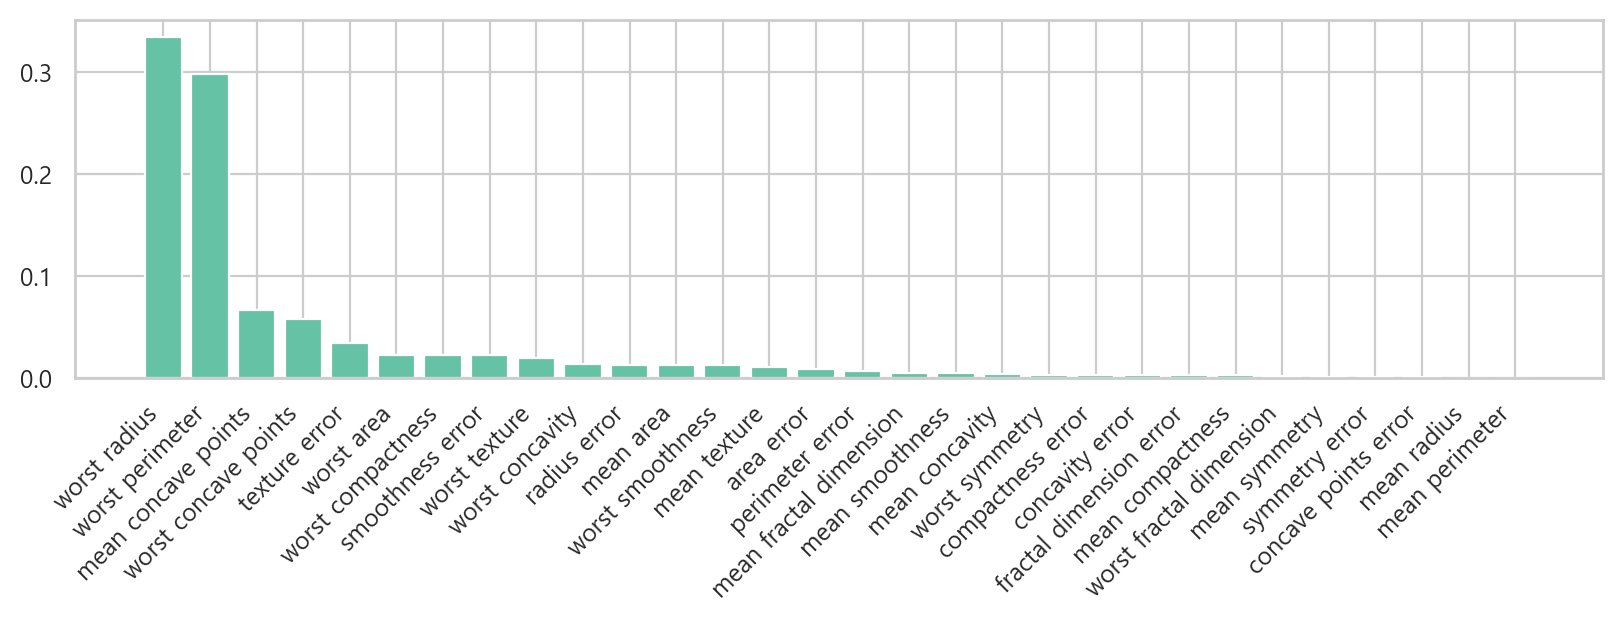

In [23]:
## xgboost 모델의 feature importance를 bar chart로 그리시오.
feature_importance = {name: importance for name, importance in zip(cancer["feature_names"], 
                                                                   xgb_best.feature_importances_)}
feature_importance_sorted = {k: v for k, v in sorted(feature_importance.items(), 
                                                     key=lambda item: item[1], 
                                                     reverse = True)}

fig, ax = plt.subplots(figsize=(8,3))

ax.bar(feature_importance_sorted.keys(), feature_importance_sorted.values())
plt.setp(ax.get_xticklabels(), ha="right", rotation=45);